In [1]:
import graspologic as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import multipletests

import hyppo
from hyppo.ksample import MANOVA, KSample
from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_fa_corr,
    load_vertex_df,
    load_vertex_metadata,
    load_volume,
    load_volume_corr,
)

In [2]:
vertex_df = load_vertex_df()
vols, labels = load_volume()

# normalize volumes
vols /= vols.sum(axis=1, keepdims=True)
unique_labels = np.unique(labels)

# make distance matrices
vol_dists = np.array([squareform(pdist(v.reshape(-1, 1))) for v in vols])

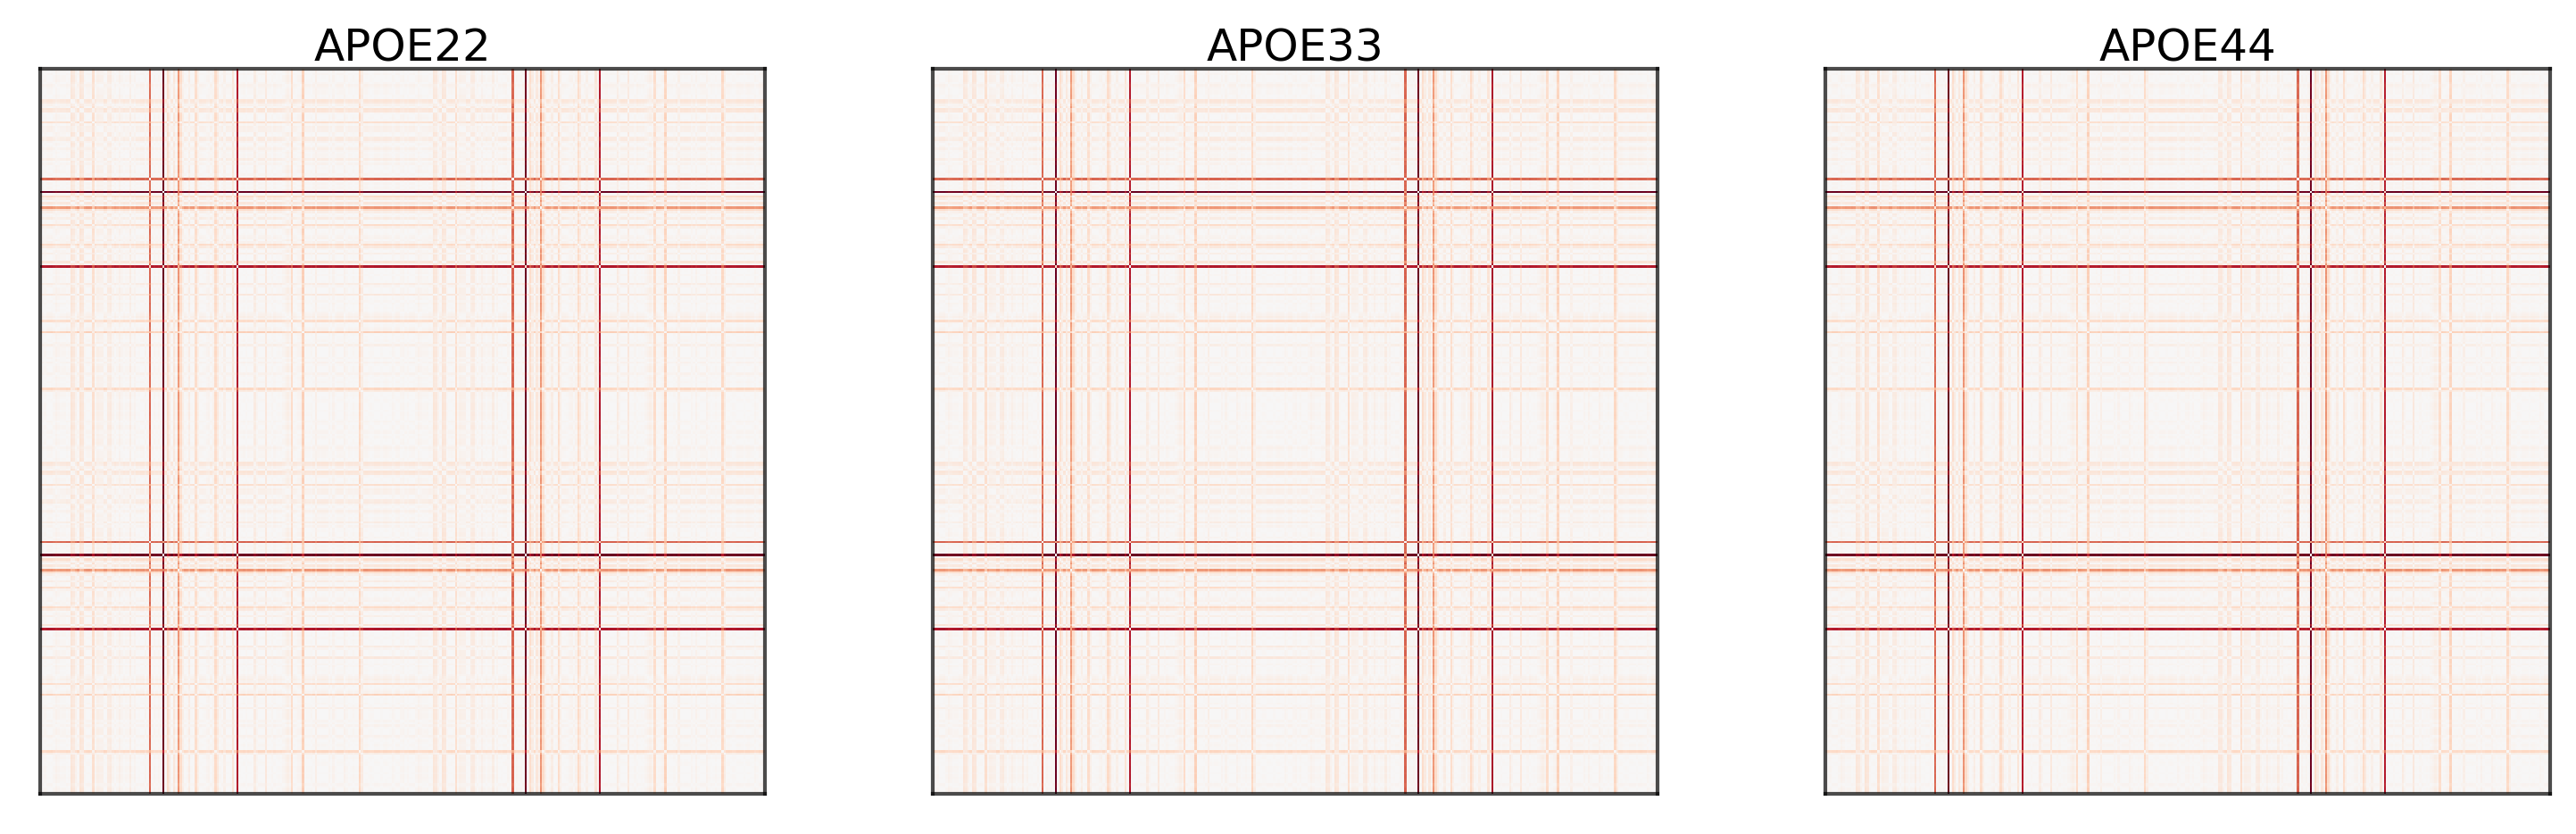

In [3]:
means = [vol_dists[labels == label].mean(axis=0) for label in np.unique(labels)]

## plot the mean differences per genotype
fig, ax = plt.subplots(
    ncols=3,
    figsize=(10, 3),
    constrained_layout=True,
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)

for idx, label in enumerate(np.unique(labels)):
    data = vol_dists[labels == label].mean(axis=0)
    gp.plot.adjplot(
        means[idx],
        ax=ax[idx],
        # meta=vertex_name,
        # group=["Hemisphere_abbrev"],
    )
    ax[idx].set_title(f"{label}", pad=0, size=12)

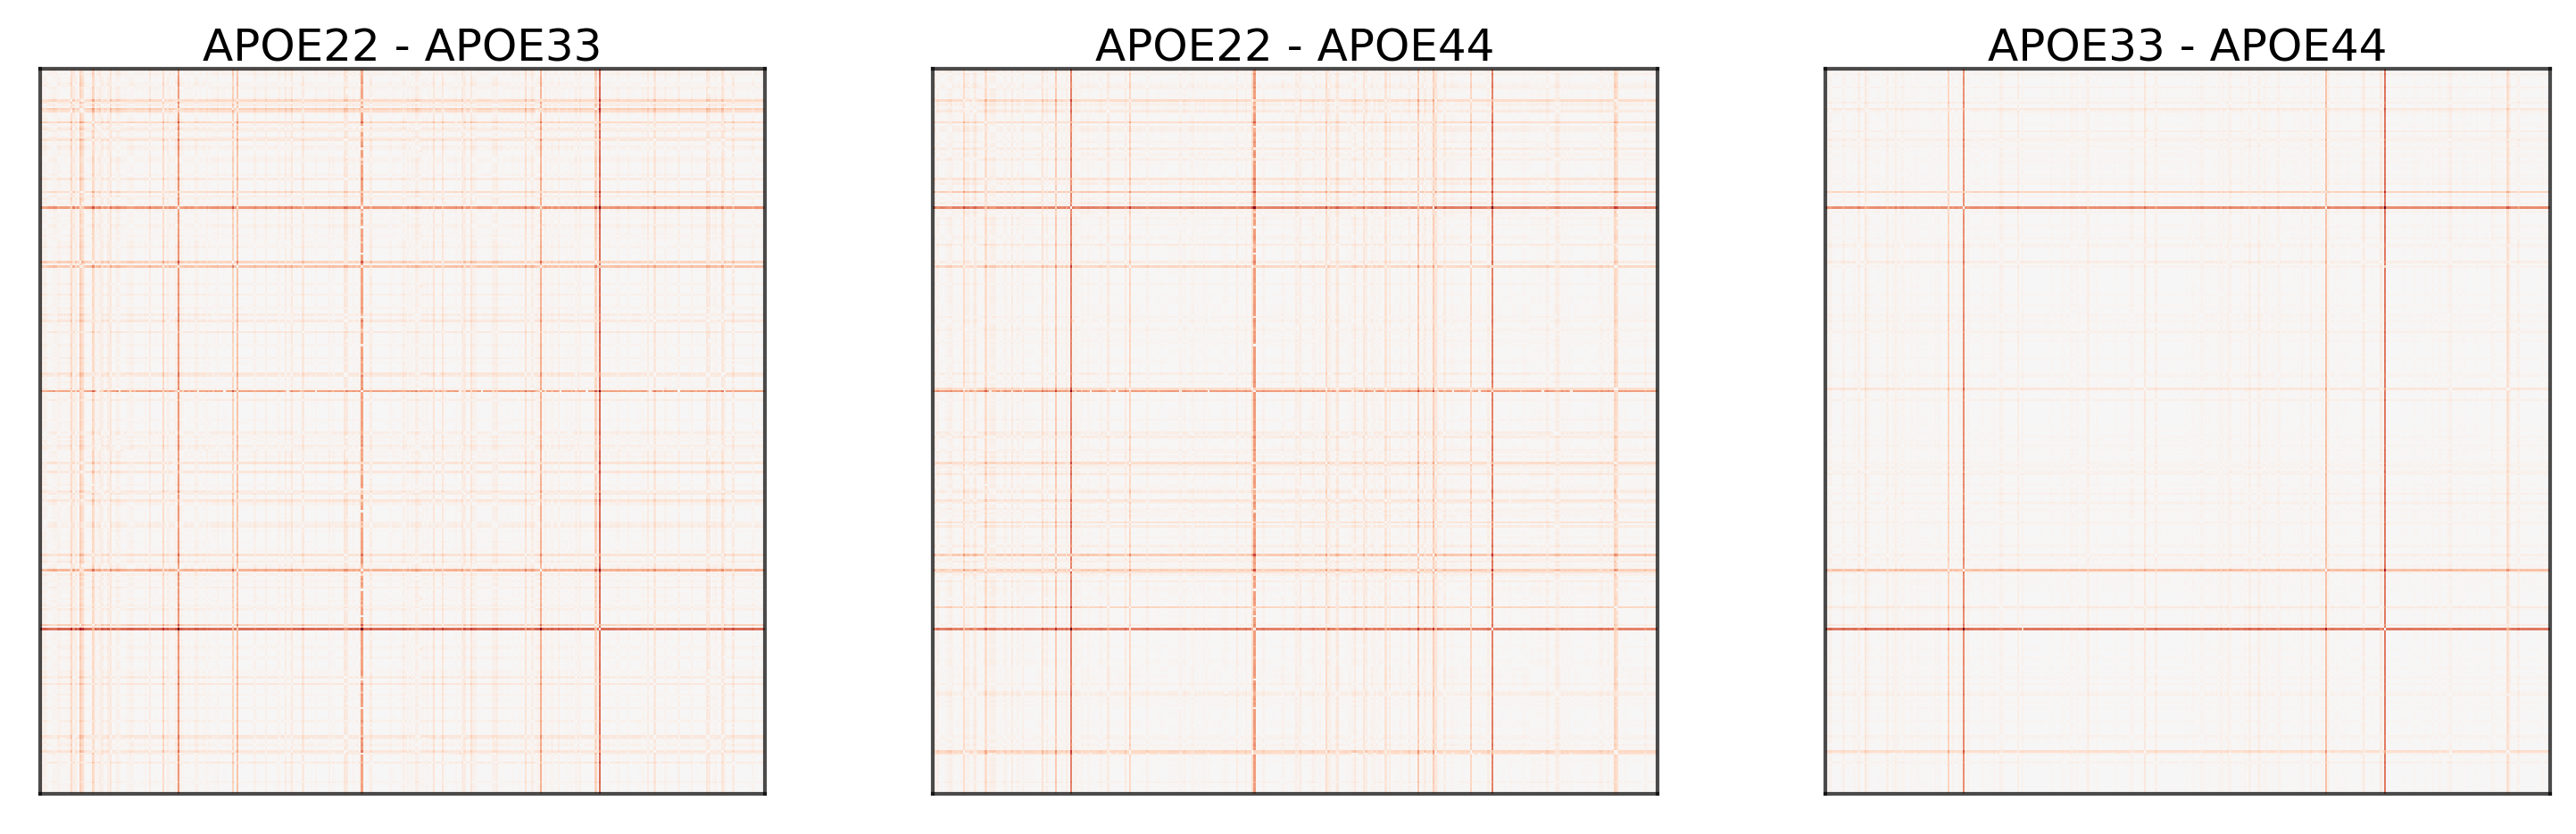

In [4]:
## plot the absolute difference in means
fig, ax = plt.subplots(
    ncols=3,
    figsize=(10, 3),
    constrained_layout=True,
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)

for idx, (label1, label2) in enumerate([(0, 1), (0, 2), (1, 2)]):
    data = np.abs(means[label1] - means[label2])
    gp.plot.adjplot(
        data,
        ax=ax[idx],
        # meta=vertex_name,
        # group=["Hemisphere_abbrev"],
    )
    ax[idx].set_title(f"{unique_labels[label1]} - {unique_labels[label2]}", pad=0, size=12)

## Edge-wise analysis

In [5]:
rdx, cdx = np.triu_indices_from(vol_dists[0], k=1)
n = rdx.size

In [6]:
apoe2 = vol_dists[labels == "APOE22"]
apoe3 = vol_dists[labels == "APOE33"]
apoe4 = vol_dists[labels == "APOE44"]

In [7]:
def worker(x, y, z, reps=100000, auto=False):
    stat, pval = KSample("Dcorr").test(x, y, z, auto=auto, reps=reps)

    return stat, pval

In [ ]:
res = Parallel(-1, verbose=1)(
    delayed(worker)(apoe2[:, i, j], apoe3[:, i, j], apoe4[:, i, j]) for i, j in zip(rdx, cdx)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed: 68.4min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed: 86.9min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed: 107.5min
[Parallel(n_jobs=-1)]: Done 5954 tasks      | elapsed: 130.4min
[Parallel(n_jobs=-1)]: Done 7104 tasks      | elapsed: 155.4min
[Parallel(n_jobs=-1)]: Done 8354 tasks      | elapsed: 182.6min


In [ ]:
edge_df = pd.DataFrame(res, columns=["stat", "pvalue"])

edge_df["rdx"] = rdx
edge_df["cdx"] = cdx

for idx, row in edge_df.iterrows():
    loc1 = row["rdx"]
    region1 = vertex_df.loc[loc1, ["Hemisphere", "Structure"]]

    loc2 = row["cdx"]
    region2 = vertex_df.loc[loc2, ["Hemisphere", "Structure"]]

    edge_df.loc[idx, "region1"] = "-".join(region1.values)
    edge_df.loc[idx, "region2"] = "-".join(region2.values)

In [ ]:
significant, corrected_pvalue, _, _ = multipletests(edge_df.pvalue, method="fdr_bh")

In [ ]:
edge_df["corrected_pvalue"] = corrected_pvalue
edge_df["significant"] = significant

In [25]:
edge_df.sort_values(["pvalue", "stat"], ascending=[True, False]).head(30)

,stat,pvalue,rdx,cdx,region1,region2,corrected_pvalue,significant
33434,0.501310,0.00001,124,141,L-Lateral_Olfactory_Tract,L-Medial_Lemniscus,0.052762,False
33418,0.452451,0.00001,124,125,L-Lateral_Olfactory_Tract,L-Ventral_Hippocampal_Commissure,0.052762,False
50236,0.429288,0.00002,234,278,R-Periaquaductal_Grey,R-Pontine_Reticular_Nucleus,0.052762,False
33564,0.387769,0.00002,124,271,L-Lateral_Olfactory_Tract,R-Trigeminal_Sensory_Nucleus,0.052762,False
15816,0.372999,0.00002,51,262,L-Dorsal_Tenia_Tecta,R-Parabrachial_Nucleus,0.052762,False
18975,0.373225,0.00003,63,139,L-Striatum,L-Medial_Longitudinal_Fasciculus_and_Tectospin...,0.052762,False
18976,0.411637,0.00004,63,140,L-Striatum,L-Spinocerebellar_Tract,0.052762,False
19142,0.402309,0.00004,63,306,L-Striatum,R-Spinocerebellar_Tract,0.052762,False
33600,0.400340,0.00004,124,307,L-Lateral_Olfactory_Tract,R-Medial_Lemniscus,0.052762,False
33711,0.391122,0.00004,125,212,L-Ventral_Hippocampal_Commissure,R-Claustrum,0.052762,False


In [ ]:
edge_df.to_csv("../outs/edge_df.csv", index=False)

## vertex-wise analysis

In [ ]:
omni = gp.embed.OmnibusEmbed().fit_transform(vol_dists)

In [ ]:
apoe2 = omni[labels == "APOE22"]
apoe3 = omni[labels == "APOE33"]
apoe4 = omni[labels == "APOE44"]

In [ ]:
res = Parallel(-1, verbose=1)(
    delayed(worker)(apoe2[:, i, :], apoe3[:, i, :], apoe4[:, i, :]) for i in range(apoe2.shape[1])
)

In [ ]:
region_df = pd.DataFrame(res, columns=["stat", "pvalue"])

region_df["idx"] = np.arange(apoe2.shape[1])

for idx, row in region_df.iterrows():
    loc = row["idx"]
    region = vertex_df.loc[loc, ["Hemisphere", "Structure"]]

    region_df.loc[idx, "region"] = "-".join(region.values)

In [ ]:
significant, corrected_pvalue, _, _ = multipletests(region_df.pvalue, method="fdr_bh")

In [ ]:
region_df["corrected_pvalue"] = corrected_pvalue
region_df["significant"] = significant

In [ ]:
region_df.sort_values("pvalue").head(15)

In [ ]:
significant.sum()

In [ ]:
region_df.to_csv("../outs/region_df.csv", index=False)

In [24]:
region_df.sort_values(["pvalue", "stat"], ascending=[True, False]).head(30)

,stat,pvalue,idx,region,corrected_pvalue,significant
63,0.324864,0.000340,63,L-Striatum,0.112879,False
2,0.199619,0.005300,2,L-Cingulate_Cortex_Area_24b,0.872045,False
256,0.184873,0.007880,256,R-Cerebellar_Cortex,0.872045,False
18,0.149728,0.016970,18,L-Primary_Motor_Cortex,0.992711,False
168,0.142411,0.020510,168,R-Cingulate_Cortex_Area_24b,0.992711,False
246,0.141086,0.022460,246,R-Superior_Colliculus,0.992711,False
28,0.129219,0.027100,28,L-Primary_Somatosensory_Cortex_Jaw_Region,0.992711,False
0,0.129916,0.027530,0,L-Cingulate_Cortex_Area_24a,0.992711,False
218,0.111095,0.038990,218,R-Ectorhinal_Cortex,0.992711,False
112,0.111399,0.039700,112,L-Pontine_Reticular_NucleusCaudal,0.992711,False
